Another approach: 

* include the other 3 variables including the year, temp (shift to t+1), month_sin, month_cos
* Do the early stopping where the validation is minimum. 
* plot the residual 

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.python import keras
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
import tensorflow as tf
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

np.random.seed(7)

In [80]:
path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\geopy\france_cleaned"

df = pd.read_csv(path+'\\'+'Alsace.csv')


In [81]:
def make_cyclic_sin(month):
    a = np.sin((month-1)*(2.*np.pi/12))
    return a
def make_cyclic_cos(month):
    b = np.cos((month-1)*(2.*np.pi/12))
    return b 

In [82]:
temp_df = df[df['PARAMETER'] == 'T2M']
temp_df = temp_df.drop('ANN', axis = 1)
#hum_df = data[data['PARAMETER'] == 'RH2M']

In [83]:
temp_df = temp_df.rename(columns = {'YEAR':'year','JAN':1, 'FEB':2,'MAR':3, 'APR':4, 'MAY':5,'JUN':6,
                         'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12})
temp_df = temp_df.drop(['PARAMETER','LAT','LON'], axis = 1)

temp_df.set_index('year', inplace = True)
df = pd.concat([temp_df.stack()], axis=1)
df.reset_index(inplace = True)

df.rename(columns = {'level_1':'month',0:'avg_temp'}, inplace = True)

# encoding for months 
#cyclic encoding from deep learning notebook
df['month_sin'] = df['month'].apply(lambda row: make_cyclic_sin(row))
df['month_cos'] = df['month'].apply(lambda row: make_cyclic_cos(row))

df['date'] = df[['year','month']].astype(str).apply('-'.join, axis=1)

df.date = pd.to_datetime(df.date)
df = df.set_index('date')

In [84]:
df.tail()

,year,month,avg_temp,month_sin,month_cos
date,,,,,
2019-08-01,2019,8,20.02,-0.500000,-8.660254e-01
2019-09-01,2019,9,15.32,-0.866025,-5.000000e-01
2019-10-01,2019,10,11.47,-1.000000,-1.836970e-16
2019-11-01,2019,11,4.60,-0.866025,5.000000e-01
2019-12-01,2019,12,2.99,-0.500000,8.660254e-01


In [85]:
# add the unlablled data
unlabelled_dataset = pd.read_excel('to_predict_mult.xlsx')
unlabelled_dataset['date'] = unlabelled_dataset[['year','month']].astype(str).apply('-'.join, axis=1)
unlabelled_dataset.date = pd.to_datetime(unlabelled_dataset.date)
unlabelled_dataset = unlabelled_dataset.set_index('date')
unlabelled_dataset.head()

,year,avg_temp,month,month_sin,month_cos
date,,,,,
2020-01-01,2020,NaN,1,0.000000,1.000000e+00
2020-02-01,2020,NaN,2,0.500000,8.660254e-01
2020-03-01,2020,NaN,3,0.866025,5.000000e-01
2020-04-01,2020,NaN,4,1.000000,6.123234e-17
2020-05-01,2020,NaN,5,0.866025,-5.000000e-01


In [86]:
# shifting the avg_temp to t+1 
df['avg_temp'] = df['avg_temp'].shift(1)

In [87]:
# removing the nan value 
df = df[1:]

In [88]:
# include the other 3 variables including the year, temp (shift to t+1), month_sin, month_cos

# 80 percent for the training set and 20 percent for the validation on the labelled data
y = df.avg_temp
X = df.drop('month', axis =1)
valid_and_test_size = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_and_test_size*2, random_state=42, shuffle=False)

In [89]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(373, 4)
(373,)
(94, 4)
(94,)


In [90]:
X_train.head()

,year,avg_temp,month_sin,month_cos
date,,,,
1981-02-01,1981,-2.68,0.500000,8.660254e-01
1981-03-01,1981,-1.23,0.866025,5.000000e-01
1981-04-01,1981,6.74,1.000000,6.123234e-17
1981-05-01,1981,8.99,0.866025,-5.000000e-01
1981-06-01,1981,12.46,0.500000,-8.660254e-01


In [91]:
# from series convert to array
y_train = y_train.values.reshape(len(y_train),1)
#y_test = y_test.values.reshape(len(y_test),1)
y_valid = y_valid.values.reshape(len(y_valid),1)

In [14]:
# normalize using minmax scaler
scaler = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train[['year','avg_temp','month_cos','month_sin']] = scaler.fit_transform(X_train)
X_valid[['year','avg_temp','month_cos','month_sin']] = scaler.fit_transform(X_valid)
X_test[['YEAR','avg_temp','month_sin','month_cos']] = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
#y_test = scaler.fit_transform(y_test)
y_valid = scaler.fit_transform(y_valid)

In [15]:
X_train.tail()

,year,avg_temp,month_sin,month_cos
date,,,,
2011-10-01,0.967742,0.747300,0.500000,0.000000
2011-11-01,0.967742,0.532242,0.750000,0.066987
2011-12-01,0.967742,0.391489,0.933013,0.250000
2012-01-01,1.000000,0.316530,1.000000,0.500000
2012-02-01,1.000000,0.270704,0.933013,0.750000


In [16]:
y_train.shape

(373, 1)

In [17]:
X_valid.tail()

,year,avg_temp,month_sin,month_cos
date,,,,
2019-08-01,1.0,0.981673,0.066987,0.250000
2019-09-01,1.0,0.944622,0.250000,0.066987
2019-10-01,1.0,0.757371,0.500000,0.000000
2019-11-01,1.0,0.603984,0.750000,0.066987
2019-12-01,1.0,0.330279,0.933013,0.250000


In [18]:
y_valid.shape

(94, 1)

In [19]:
look_back=12
FORECAST_DISTANCE=1 # forecast on the next month
n_features = len(X_train.columns)


In [20]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

In [21]:
segmenter = SegmentXYForecast(width=look_back, step=1, y_func=last, forecast=FORECAST_DISTANCE) 

In [22]:
# the segmenter will segment the data according to the parameters set.
X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train.values],[y_train.flatten()])
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid.values],[y_valid.flatten()])

In [23]:
X_train_rolled.shape

(361, 12, 4)

In [24]:
y_train_rolled.shape

(361,)

In [25]:
X_valid_rolled.shape

(82, 12, 4)

In [26]:
y_valid_rolled.shape

(82,)

In [27]:
#####

In [28]:
BATCH_SIZE = 5
EPOCHS = 30
DROPOUT_RATE= 0.01
LSTM_UNIT_SIZE = 5

# Build the model 
model = Sequential()
model.add(LSTM(LSTM_UNIT_SIZE, activation = 'relu',input_shape = (look_back, n_features)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1))


#compile the model
#opt = Adam(lr=0.01, clipnorm=1.0)
#model.compile(loss='mean_squared_error', optimizer=opt)
model.compile(optimizer = 'adam', loss = 'mse')

# fit the model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
mc = ModelCheckpoint('best_model_mult_test.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
                    
history = model.fit(X_train_rolled, y_train_rolled, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_valid_rolled,y_valid_rolled), callbacks = [es,mc]) #, callbacks = es

Train on 361 samples, validate on 82 samples
Epoch 1/30
361/361 [==============================] - 1s 3ms/step - loss: 0.1636 - val_loss: 0.0739

Epoch 00001: val_loss improved from inf to 0.07393, saving model to best_model_mult_test.h5
Epoch 2/30
361/361 [==============================] - 1s 2ms/step - loss: 0.0422 - val_loss: 0.0490

Epoch 00002: val_loss improved from 0.07393 to 0.04896, saving model to best_model_mult_test.h5
Epoch 3/30
361/361 [==============================] - 1s 2ms/step - loss: 0.0246 - val_loss: 0.0283

Epoch 00003: val_loss improved from 0.04896 to 0.02829, saving model to best_model_mult_test.h5
Epoch 4/30
361/361 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0155

Epoch 00004: val_loss improved from 0.02829 to 0.01551, saving model to best_model_mult_test.h5
Epoch 5/30
361/361 [==============================] - 1s 2ms/step - loss: 0.0083 - val_loss: 0.0120

Epoch 00005: val_loss improved from 0.01551 to 0.01202, saving model t

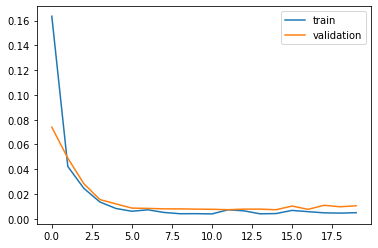

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [30]:
# get the saved model 

from keras.models import load_model
saved_model = load_model('best_model_mult_test.h5')

In [31]:
train_predict = saved_model.predict(X_train_rolled) 

In [32]:
train_predict.shape

(361, 1)

In [33]:
train_predict_orig = scaler.inverse_transform(train_predict)

In [34]:
test_predict_valid = saved_model.predict(X_valid_rolled)

In [35]:
test_predict_valid.shape

(82, 1)

In [36]:
test_predict_valid_origina = scaler.inverse_transform(test_predict_valid)

In [37]:
y_train = scaler.inverse_transform([y_train_rolled]) # to get the true value
y_valid = scaler.inverse_transform([y_valid_rolled])

In [38]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict_orig[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict_orig[:,0])))
print('valid Mean Absolute Error:', mean_absolute_error(y_valid[0], test_predict_valid_origina[:,0]))
print('valid Root Mean Squared Error:',np.sqrt(mean_squared_error(y_valid[0], test_predict_valid_origina[:,0])))
print('\n')

Train Mean Absolute Error: 1.1588053195294863
Train Root Mean Squared Error: 1.4704159738354468
valid Mean Absolute Error: 1.7854815761635943
valid Root Mean Squared Error: 2.1414877225985056




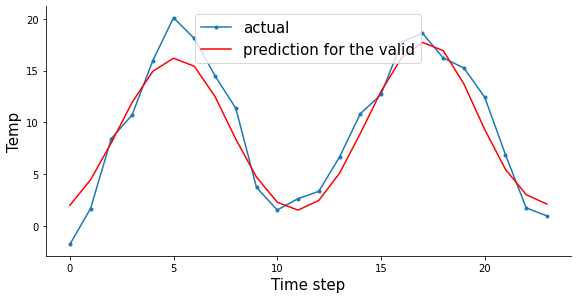

In [39]:
# validation

import seaborn as sns

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_valid[0][:24], marker='.', label="actual") 
plt.plot(aa, test_predict_valid_origina[:,0][:24], 'r', label="prediction for the valid")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

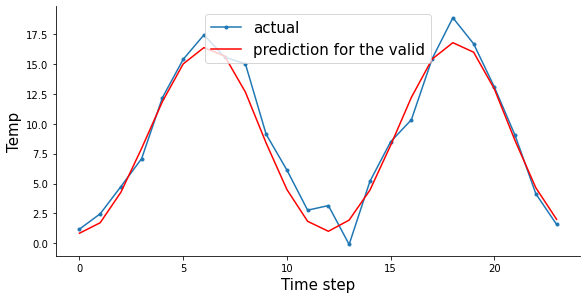

In [40]:

# training

import seaborn as sns

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_train[0][:24], marker='.', label="actual") 
plt.plot(aa, train_predict_orig[:,0][:24], 'r', label="prediction for the valid")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [41]:
# plot residuals for training
original_y_train_df = y_train.reshape(-1,1)
original_y_train =  pd.DataFrame(original_y_train_df).rename(columns = {0:'y'}) 
prediction_train = pd.DataFrame(train_predict_orig).rename(columns = {0:'y_hat'}) 
df_residual_train = pd.concat([original_y_train,prediction_train], axis = 1)
df_residual_train['residual'] = df_residual_train['y'] - df_residual_train['y_hat']

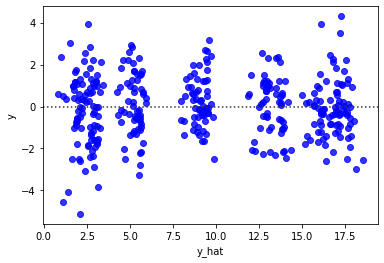

In [42]:
# plot residuals for training
sns_plot = sns.residplot(x ='y_hat', y = 'y', data = df_residual_train, color = 'blue')
sns_plot

In [43]:
# plot residuals for validation 
# plot residuals for training
original_y_valid_df = y_valid.reshape(-1,1)
original_y_valid =  pd.DataFrame(original_y_valid_df).rename(columns = {0:'y'}) 
prediction_valid = pd.DataFrame(test_predict_valid_origina).rename(columns = {0:'y_hat'}) 
df_residual_valid = pd.concat([original_y_valid,prediction_valid], axis = 1)
df_residual_valid['residual'] = df_residual_valid['y'] - df_residual_valid['y_hat']


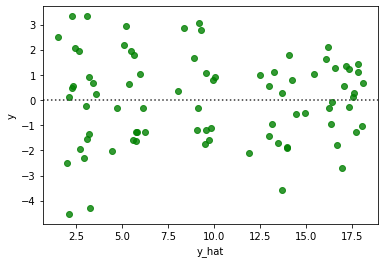

In [44]:
sns_plot_valid = sns.residplot(x ='y_hat', y = 'y', data = df_residual_valid, color = 'green')
sns_plot_valid

# Predicting the future dates 

In [68]:
test = X_valid.tail(12)

In [69]:
test

,year,avg_temp,month_sin,month_cos
date,,,,
2019-01-01,1.0,0.263745,1.000000,0.500000
2019-02-01,1.0,0.131474,0.933013,0.750000
2019-03-01,1.0,0.272510,0.750000,0.933013
2019-04-01,1.0,0.409562,0.500000,1.000000
2019-05-01,1.0,0.509960,0.250000,0.933013
2019-06-01,1.0,0.599203,0.066987,0.750000
2019-07-01,1.0,0.934263,0.000000,0.500000
2019-08-01,1.0,0.981673,0.066987,0.250000
2019-09-01,1.0,0.944622,0.250000,0.066987


In [70]:
no_label = unlabelled_dataset[['year','avg_temp','month_sin','month_cos']]

In [71]:
no_label[['year','avg_temp','month_sin','month_cos']] = scaler.transform(no_label)

In [72]:
unlabelled_df = pd.concat([test,no_label])

In [73]:
unlabelled_df # use 2019

,year,avg_temp,month_sin,month_cos
date,,,,
2019-01-01,1.00000,0.263745,1.000000,0.500000
2019-02-01,1.00000,0.131474,0.933013,0.750000
2019-03-01,1.00000,0.272510,0.750000,0.933013
2019-04-01,1.00000,0.409562,0.500000,1.000000
2019-05-01,1.00000,0.509960,0.250000,0.933013
2019-06-01,1.00000,0.599203,0.066987,0.750000
2019-07-01,1.00000,0.934263,0.000000,0.500000
2019-08-01,1.00000,0.981673,0.066987,0.250000
2019-09-01,1.00000,0.944622,0.250000,0.066987


In [76]:
# for loop over to 

pred_list = []
forecast_months = 24 # 2020-2021

prediction = 0

for row in range(forecast_months):
    #print(row)
    look_back = 12
    test_set = unlabelled_df[row:look_back+row] # [0:12]
    if row != 0:
        test_set.iloc[11][1] = prediction
    #print(counter)
    #display(test_set)
    x_test_reshaped = test_set.values.reshape(1,12,4)
    predict = saved_model.predict(x_test_reshaped)
    prediction = predict[0][0] ## append this to the next test set
    pred_list.append(prediction) 
    

In [78]:
len(pred_list)

24

In [52]:
# empty prediction is 2019,2020,2021
empty_df = pd.read_excel('empty_prediction.xlsx')
empty_df.drop('avg_temp',axis =1, inplace = True)

In [53]:
final_prediction = pd.concat([empty_df,prediction_df], axis = 1).rename(columns = {0:'avg_temp'})

NameError: name 'prediction_df' is not defined

In [ ]:
cols = list(final_prediction)
# move the column to head of list using index, pop and insert
cols.insert(1, cols.pop(cols.index('avg_temp')))

In [ ]:
df = final_prediction.ix[:, cols]

In [ ]:
df

In [ ]:
df[['YEAR','avg_temp','month_sin','month_cos']] = scaler.inverse_transform(df)

In [ ]:
df